In [5]:
!pip install scanpy
!pip install leidenalg



  Using cached scanpy-1.9.8-py3-none-any.whl.metadata (6.0 kB)
  Using cached anndata-0.10.5.post1-py3-none-any.whl.metadata (6.5 kB)
  Using cached natsort-8.4.0-py3-none-any.whl.metadata (21 kB)
  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached session_info-1.0.0.tar.gz (24 kB)
  Preparing metadata (setup.py) ... done
  Using cached array_api_compat-1.4.1-py3-none-any.whl.metadata (13 kB)
  Using cached stdlib_list-0.10.0-py3-none-any.whl.metadata (3.3 kB)
Using cached scanpy-1.9.8-py3-none-any.whl (2.0 MB)
Using cached anndata-0.10.5.post1-py3-none-any.whl (121 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)
Using cached natsort-8.4.0-py3-none-any.whl (38 kB)
Using cached array_api_compat-1.4.1-py3-none-any.whl (30 kB)
Using cached stdlib_list-0.10.0-py3-none-any.whl (79 kB)
  Created wheel for session-info: filename=session_info-1.0.0-py3-none-any.whl size=8023 sha256=3b8ff02b577f42cf402199aa055ff936314e8ad426133d4ae87ff402ea517d86
  Stored i

In [6]:
import numpy as np
import pandas as pd
import scanpy as sc
import os
import random

from scipy.spatial.distance import cdist
from scipy.spatial.distance import pdist, squareform
from typing import List
## Imports for plotting
import matplotlib.pyplot as plt
import seaborn as sns

## PyTorch
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim

import pytorch_lightning as pl
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from collections import defaultdict
import optuna
import gc


In [7]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

2024-02-06 18:56:11.571217: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-06 18:56:11.571425: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-06 18:56:11.751379: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


scanpy==1.9.8 anndata==0.10.5.post1 umap==0.5.5 numpy==1.26.3 scipy==1.11.4 pandas==2.2.0 scikit-learn==1.2.2 statsmodels==0.14.1 igraph==0.11.3 pynndescent==0.5.11


In [8]:
SEED = 111
random.seed(SEED)
np.random.seed(SEED)

In [9]:
# In this notebook, we use data loaders with heavier computational processing. It is recommended to use as many
# workers as possible in a data loader, which corresponds to the number of CPU cores
NUM_WORKERS = os.cpu_count()
  
# Setting the seed
pl.seed_everything(42)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)
print("Number of workers:", NUM_WORKERS)

Device: cpu
Number of workers: 4


In [10]:
# Load the AnnData object containing single-cell RNA-Seq data from the specified file
adata = sc.read_h5ad("/kaggle/input/a-blood-atlas-of-covid-19-combat-preprocessed/combat_processed.h5ad")
adata

AnnData object with n_obs × n_vars = 783704 × 3000
    obs: 'Annotation_cluster_id', 'Annotation_cluster_name', 'Annotation_minor_subset', 'Annotation_major_subset', 'Annotation_cell_type', 'GEX_region', 'QC_ngenes', 'QC_total_UMI', 'QC_pct_mitochondrial', 'QC_scrub_doublet_scores', 'TCR_chain_composition', 'TCR_clone_ID', 'TCR_clone_count', 'TCR_clone_proportion', 'TCR_contains_unproductive', 'TCR_doublet', 'TCR_chain_TRA', 'TCR_v_gene_TRA', 'TCR_d_gene_TRA', 'TCR_j_gene_TRA', 'TCR_c_gene_TRA', 'TCR_productive_TRA', 'TCR_cdr3_TRA', 'TCR_umis_TRA', 'TCR_chain_TRA2', 'TCR_v_gene_TRA2', 'TCR_d_gene_TRA2', 'TCR_j_gene_TRA2', 'TCR_c_gene_TRA2', 'TCR_productive_TRA2', 'TCR_cdr3_TRA2', 'TCR_umis_TRA2', 'TCR_chain_TRB', 'TCR_v_gene_TRB', 'TCR_d_gene_TRB', 'TCR_j_gene_TRB', 'TCR_c_gene_TRB', 'TCR_productive_TRB', 'TCR_chain_TRB2', 'TCR_v_gene_TRB2', 'TCR_d_gene_TRB2', 'TCR_j_gene_TRB2', 'TCR_c_gene_TRB2', 'TCR_productive_TRB2', 'TCR_cdr3_TRB2', 'TCR_umis_TRB2', 'BCR_umis_HC', 'BCR_contig_qc_HC

In [11]:
class DynamicNetwork(nn.Module):
    def __init__(self, n_input_features: int, n_output_features: int, num_layers: int, hidden_size: int):
        """
        Initialize a dynamic neural network.

        Args:
            n_input_features (int): Number of input features.
            n_output_features (int): Number of output features.
            num_layers (int): Number of hidden layers.
            hidden_size (int): Size of the hidden layers.
        """
        super().__init__()

        layers = []
        for _ in range(num_layers):
            
            # Add a linear layer followed by a ReLU activation
            layers.extend([
                nn.Linear(n_input_features, hidden_size),
                nn.ReLU()
            ])
            n_input_features = hidden_size  # Update the number of input features for the next layer

        # Add the final linear layer
        layers.append(nn.Linear(hidden_size, n_output_features))

        # Create a sequential module with the defined layers
        self.fc = nn.Sequential(*layers) # скелет

    def forward(self, x):
        """
        Forward pass through the neural network.
        Args:
            x (tensor): Input data.
        Returns:
            tensor: Output of the network.
        """
        return self.fc(x)

In [12]:
class SamplesDataset(Dataset):
    def __init__(self, data, unique_categories: List[str], sample_col: str, layer: str = "X_pca"):
        """
        A dataset that holds sample cells based on unique categories.

        Args:
            data (YourDataType): The dataset containing the data.
            unique_categories (List[str]): List of unique category values.
            sample_col (str): The column indicating sample information.
            layer (str, optional): The data layer to be used. Defaults to "X_pca".
        """
        self.data = data
        self.unique_categories = unique_categories
        self.sample_cells = []
        self.sample_col = sample_col
        self.layer = layer
        
        for sample_id in self.unique_categories:
            sample = self.data.obsm[layer][self.data.obs[sample_col] == sample_id]
            if len(sample) > 0:
                self.sample_cells.append(sample)

    def __len__(self):
        return len(self.sample_cells)

    def __getitem__(self, idx):
        return self.sample_cells[idx]

In [13]:

model = DynamicNetwork(n_input_features=50, n_output_features=30, num_layers=3, hidden_size=200)
model.load_state_dict(torch.load('/kaggle/input/farhad-kimi-contrastive/Models/model_4000_16_3_200_200_0.009869211075062357.pt', map_location=torch.device('cpu')))
model.eval()

DynamicNetwork(
  (fc): Sequential(
    (0): Linear(in_features=50, out_features=200, bias=True)
    (1): ReLU()
    (2): Linear(in_features=200, out_features=200, bias=True)
    (3): ReLU()
    (4): Linear(in_features=200, out_features=200, bias=True)
    (5): ReLU()
    (6): Linear(in_features=200, out_features=30, bias=True)
  )
)

In [14]:
#cell_tye representation
adata.obs['patient_celltype'] = adata.obs['scRNASeq_sample_ID'].astype(str) + '_' + adata.obs['Annotation_cell_type'].astype(str)


patient_cell_type = adata.obs['patient_celltype'].unique()
cell_type_dataset = SamplesDataset(adata, patient_cell_type , sample_col="patient_celltype")
means_for_cell_type = []

# Iterate through the dataset to calculate the mean of each data sample along the rows (axis=0)
for data in cell_type_dataset:
    means_for_cell_type.append(data.mean(axis=0))

# Convert the list of means into a NumPy array and then into a PyTorch tensor
means_for_cell_type = torch.tensor(np.array(means_for_cell_type)).to(device)



In [15]:
adata.obs['patient_celltype'].value_counts()


patient_celltype
S00005-Ja005E-PBCa_T        7769
S00052-Ja005E-PBCa_T        7197
U00515-Ua005E-PBUa_T        7143
H00067-Ha001E-PBGa_T        7053
H00053-Ha001E-PBGa_T        6191
                            ... 
U00503-Ua005E-PBUa_PLT         1
S00042-Ja003E-PBCa_ERYTH       1
U00605-Ua005E-PBUa_ERYTH       1
G05061-Ja005E-PBCa_ERYTH       1
S00033-Ja005E-PBCa_ERYTH       1
Name: count, Length: 997, dtype: int64

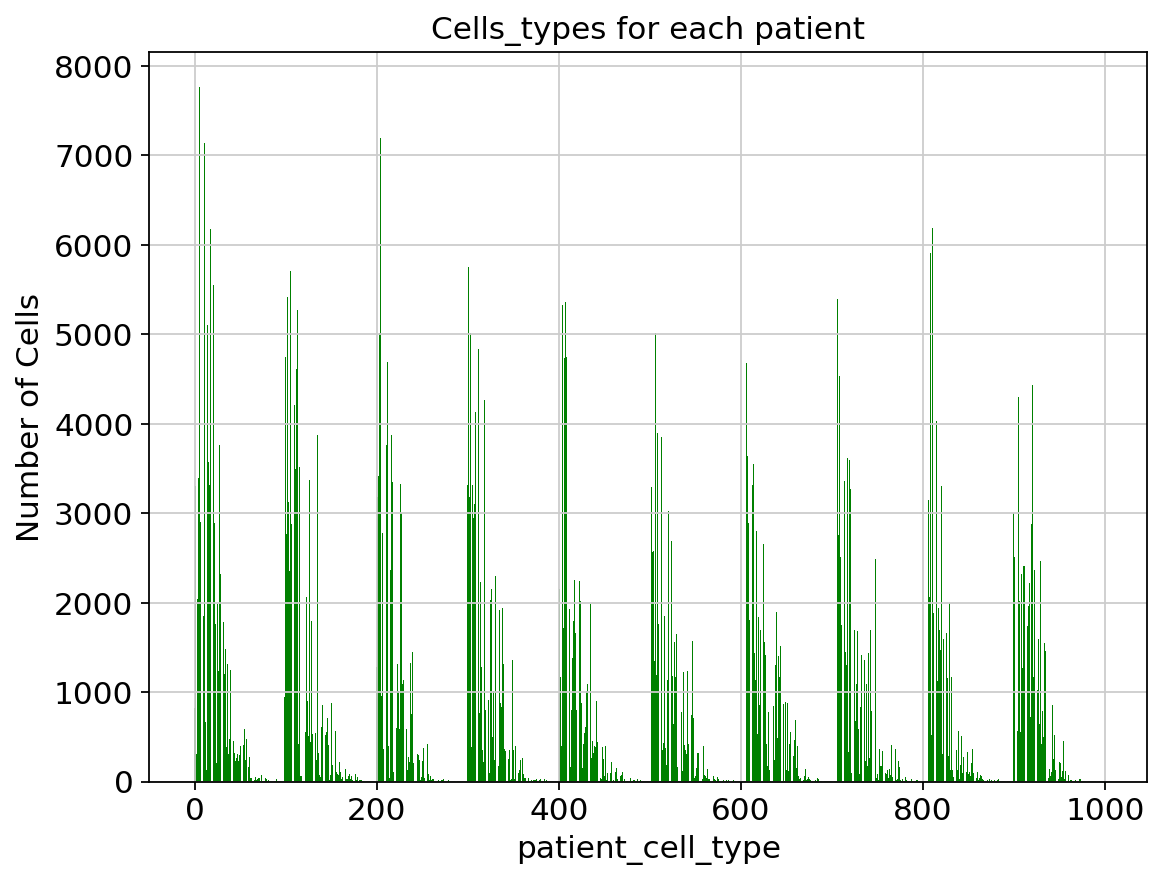

In [16]:
cells_type_per_patient = []
for patient_cells_type in cell_type_dataset:
    cells_type_per_patient.append(len(patient_cells_type))

# Create a bar chart
plt.figure(figsize=(8, 6))
plt.bar(range(len(cells_type_per_patient)), cells_type_per_patient, color='green')

# Customize axis labels and title
plt.xlabel('patient_cell_type')
plt.ylabel('Number of Cells')
plt.title('Cells_types for each patient')

# Show the bar chart
plt.show()

<Axes: ylabel='Count'>

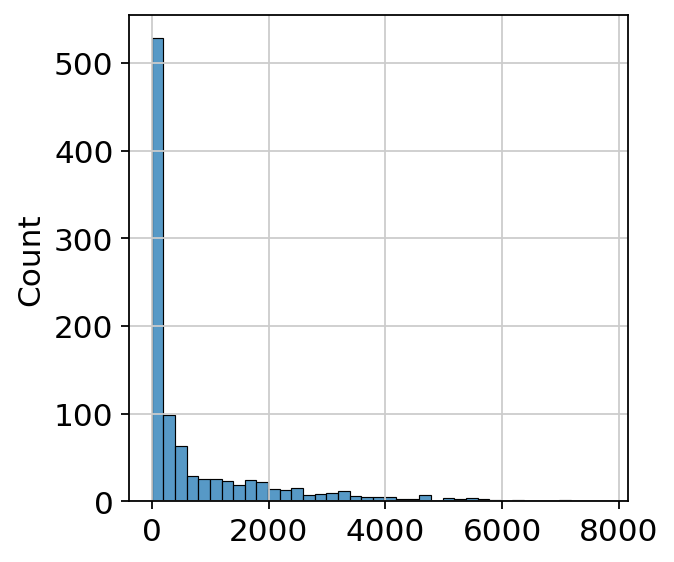

In [17]:
sns.histplot(cells_type_per_patient)

In [18]:
np.median(cells_type_per_patient)

138.0

In [19]:
with torch.no_grad():
    representation = model(means_for_cell_type).cpu().detach().numpy()
# Save the representation as a CSV file
! mkdir Representations
representation_folder = 'Representations/'
representation_df = pd.DataFrame(representation)
representation_name = f"representation_cell_type.csv"
representation_path = os.path.join(representation_folder, representation_name)
representation_df.to_csv(representation_path, index=False)

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
running Leiden clustering
    finished: found 16 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:03)


/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/opt/conda/lib/python3.10/site-packages/scanpy/plotting

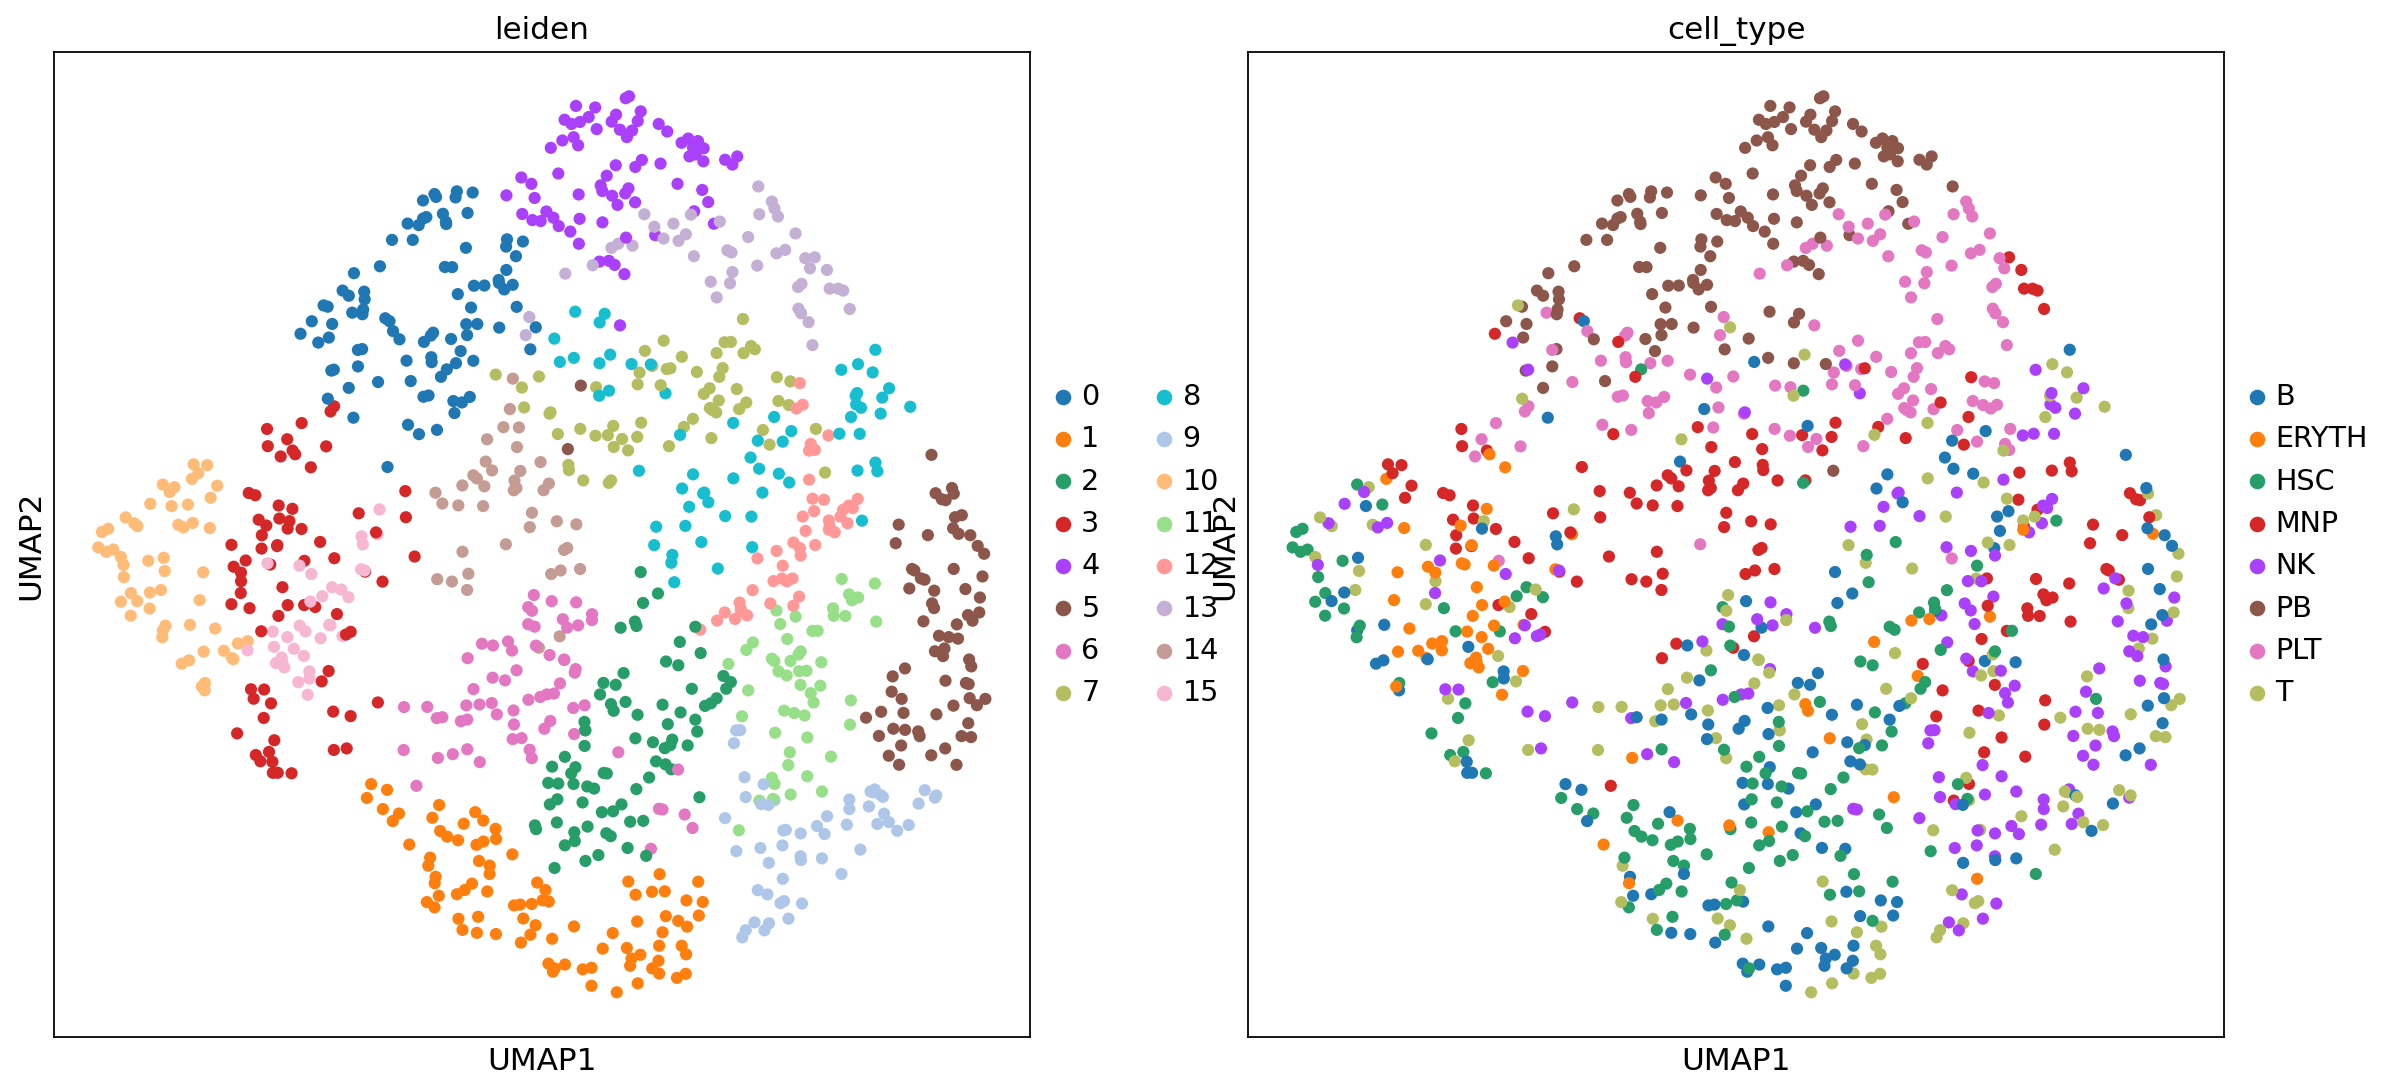

In [34]:
#outcome = adata.obs.groupby('patient_celltype')['Outcome'].mean()
outcome = adata.obs[['patient_celltype','Outcome']].drop_duplicates()
outcome = pd.DataFrame(outcome)
representation=pd.read_csv("/kaggle/working/Representations/representation_cell_type.csv")
representation = pd.DataFrame(representation)
new_adata = sc.AnnData(X=representation,obs=outcome)
new_adata.obs['cell_type']= new_adata.obs['patient_celltype'].apply(lambda x: x.split("_")[1])
new_adata.obs['cell_type'] = new_adata.obs['cell_type'].astype('category')

# Preprocessing and neighbors computation
sc.pp.neighbors(new_adata, use_rep="X")

# Run Leiden clustering algorithm
sc.tl.leiden(new_adata)

# Run UMAP
sc.tl.umap(new_adata)
sc.set_figure_params(figsize=(8, 8))
# Plot UMAP, color by 'leiden', 'cell_type', and 'outcome'
sc.pl.umap(
    new_adata,
    color=['leiden', 'cell_type'],  # Ensure 'cell_type' is included here
    legend_loc='right margin',
)


In [28]:
adata.obs['Annotation_cell_type'].value_counts()

Annotation_cell_type
T        401297
MNP      255828
NK        69927
B         44256
PB         8596
HSC        1933
PLT        1563
ERYTH       304
Name: count, dtype: int64

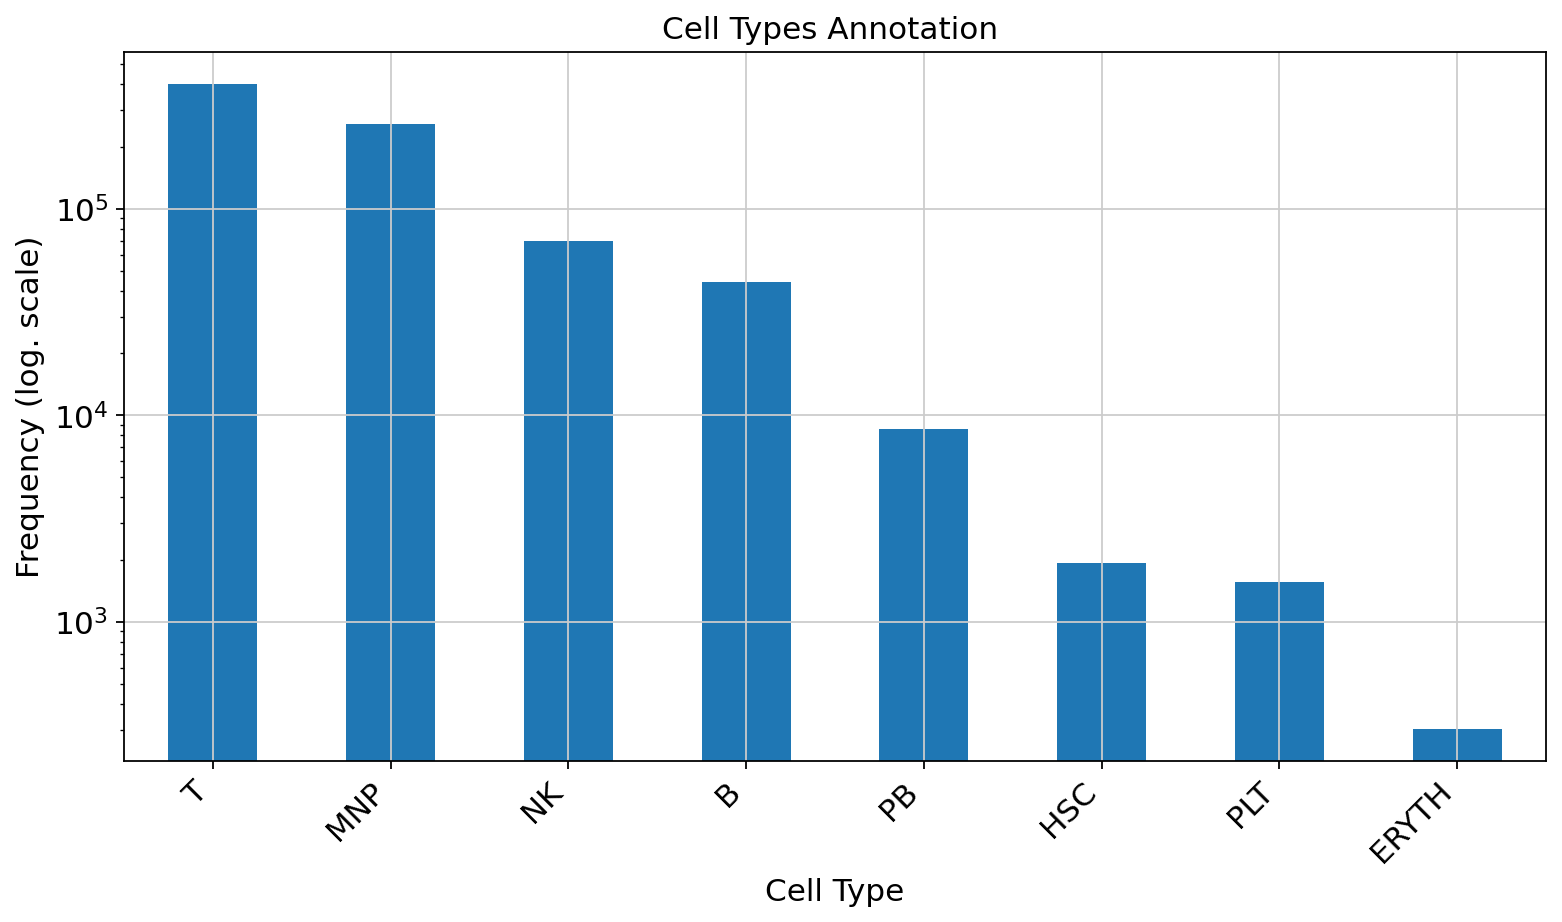

In [39]:
# Assuming 'adata.obs['Annotation_cell_type']' is a pandas Series object
# Calculate the value counts
value_counts = adata.obs['Annotation_cell_type'].value_counts()

# Plot the histogram
plt.figure(figsize=(10, 6))
value_counts.plot(kind='bar')
plt.yscale('log') 
plt.title('Cell Types Annotation ')
plt.xlabel('Cell Type')
plt.ylabel('Frequency (log. scale)')
plt.xticks(rotation=45, ha='right')  # Rotate the x labels to avoid overlap
plt.tight_layout()  # Adjust the layout to fit the labels
plt.show()